In [1]:
from IPython.core.debugger import Tracer

import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras.backend as K

from scipy import io
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D
import random
import csv
import os

np.set_printoptions(precision=4, suppress=True)

Using TensorFlow backend.


In [2]:
directory_name = './MATLAB/data/0304/'
data_amount = 1000

files_name = os.listdir(directory_name)
print(len(files_name))
X_DesignedFs = []
X_poles = []
X_Qnums = []
X_LQ = []
X_rks = []
X_yks = []
X_uks = []
X_eks = []
Z_DesignedFs = []
Z_poles = []
Z_Qnums = []
Z_LQ = []
Z_rks = []
Z_yks = []
Z_uks = []
Z_eks = []
for file in files_name:
# for file in files_name[:data_amount] + files_name[(len(files_name)//2):(len(files_name)//2+data_amount)]:
    load_data = io.loadmat(directory_name + file)
    plant = file[0]
    DesignedF = load_data[plant+'_DesignedF']
    pole = load_data[plant+'_pole'].reshape(-1)[0]
    Qnum = load_data[plant+'_Qnum'].reshape(-1)
    LQ = Qnum.shape[0]
    rk = (load_data[plant+'_rk'].reshape(-1))[7500:22500]
    yk = (load_data[plant+'_yk'].reshape(-1))[7500:22500]
    uk = (load_data[plant+'_uk'].reshape(-1))[7500:22500]
    ek = (load_data[plant+'_ek'].reshape(-1))[7500:22500]*1000
#     print(file, ek.max())
    if ek.max() < 1:
        if plant == 'X':
            X_DesignedFs.append(DesignedF)
            X_poles.append(pole)
            X_Qnums.append(Qnum)
            X_LQ.append(LQ)
            X_rks.append(rk)
            X_yks.append(yk)
            X_uks.append(uk)
            X_eks.append(ek)
        elif plant == 'Z':
#             break
            Z_DesignedFs.append(DesignedF)
            Z_poles.append(pole)
            Z_Qnums.append(Qnum)
            Z_LQ.append(LQ)
            Z_rks.append(rk)
            Z_yks.append(yk)
            Z_uks.append(uk)
            Z_eks.append(ek)
X_poles = np.array(X_poles)
X_LQ = np.array(X_LQ)
X_rks = np.array(X_rks)
X_yks = np.array(X_yks)
X_uks = np.array(X_uks)
X_eks = np.array(X_eks)
X_Qnums = np.array(X_Qnums)
Z_Qnums = np.array(Z_Qnums)
Z_poles = np.array(Z_poles)
Z_LQ = np.array(Z_LQ)
Z_rks = np.array(Z_rks)
Z_yks = np.array(Z_yks)
Z_uks = np.array(Z_uks)
Z_eks = np.array(Z_eks)
print('finish')

20040
finish


<function matplotlib.pyplot.show(*args, **kw)>

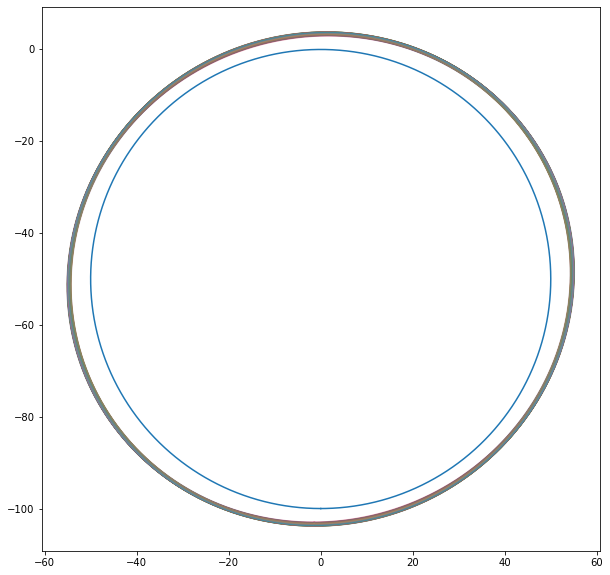

In [3]:
X = (X_rks - X_eks*10)
Z = (Z_rks - Z_eks*10)
plt.figure(figsize=(10, 10))
plt.plot(X_rks[0], Z_rks[0], alpha = 1)
for i in range(1000):
    plt.plot(X[i], Z[i], alpha = 0.3)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

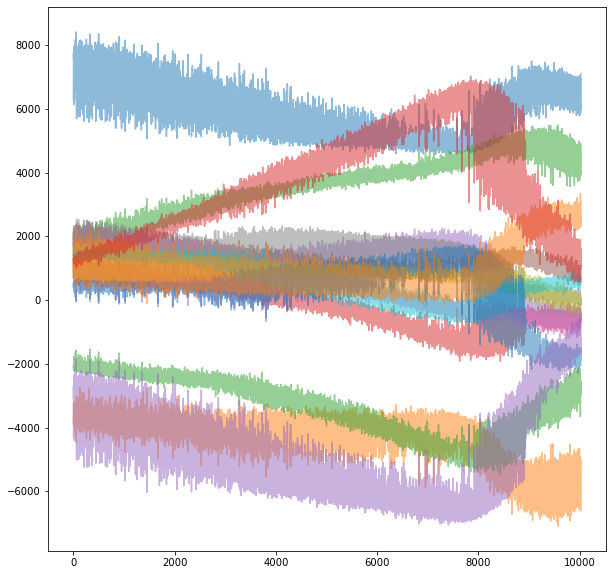

In [4]:
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.plot(X_Qnums[:,i], alpha = 0.5)
plt.show

In [5]:
X_train = np.append(X_poles.reshape(-1, 1), X_LQ.reshape(-1, 1), axis = 1)
X_train = np.append(X_train, np.array(X_DesignedFs)[:,:,1], axis = 1)
Y_train = np.array(X_Qnums)
Z_train = X_eks.max(axis = 1)

In [6]:
def my_mape(y_true, y_pred):
    return K.sum((K.abs(y_pred - y_true))/(K.abs(y_true)+0.001))

In [10]:
 # Build & Train the model
callback = EarlyStopping(monitor = 'loss', patience = 500, verbose = 1, mode = 'auto')

keras.backend.clear_session()
model = Sequential()
model.add(Dense(units=48, input_dim=X_train.shape[1], kernel_initializer='normal', activation='sigmoid'))
# model.add(BatchNormalization())
model.add(Dense(units=128, kernel_initializer='normal', activation='sigmoid'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(Dense(units=256, kernel_initializer='normal', activation='sigmoid'))
# model.add(Dropout(0.9))
model.add(Dense(units=128, kernel_initializer='normal', activation='sigmoid'))
# model.add(Dropout(0.9))
model.add(Dense(units=64, kernel_initializer='normal', activation='sigmoid'))
# model.add(Dense(units=64, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(units=15, kernel_initializer='normal', activation='sigmoid'))

# 編譯: 選擇損失函數、優化方法及成效衡量方式
# model.compile(loss=my_mape, optimizer=Adam(lr=0.00001)) 
model.compile(loss='mae', optimizer=Adam(lr=0.00001)) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 48)                1008      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6272      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                975       
Total params: 82,431
Trainable params: 82,431
Non-trainable params: 0
__________________________________________________

In [11]:
# keras.backend.clear_session()
train_history = model.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=100000, batch_size=1024, verbose=1)
# train_history = model.fit(x=X_train, y=Y_train, validation_split=0.1, epochs=10000, batch_size=1000, verbose=1, callbacks = [callback])  

Train on 9018 samples, validate on 1002 samples
Epoch 1/100000


InternalError:  Blas GEMM launch failed : a.shape=(1024, 20), b.shape=(20, 48), m=1024, n=48, k=20
	 [[node dense_1/MatMul (defined at c:\users\dalek669528\.conda\envs\pytorch\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_keras_scratch_graph_2283]

Function call stack:
keras_scratch_graph


In [ ]:
model.save('Simulator_DesignF2Qnum_0319.h5')

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(15):
    plt.plot(X_Qnums[:,i], alpha = 0.5)
plt.show


In [ ]:
Err_from_DesignF = DesignF2Errmax.predict(X_train)
Err_from_Qnum = Qnum2Errmax.predict(Y_train)

In [ ]:
# Load models
DesignF2Errmax = load_model('Simulator_DesignF2Errmax_0304.h5')
Qnum2Errmax = load_model('Simulator_Qnum2Errmax_0304.h5')


In [ ]:
Y_test = model.predict(X_train)

fig = plt.figure(figsize=(15, 8))
ax1 = host_subplot(111, axes_class=AA.Axes)
# ax1.plot(X_eks.max(axis=1)[:], label = "err")
# ax1.plot(Y_test[:], label = "pred", alpha=0.3)
# ax1.set_ylabel('err (um)')
for i in range(15):
    ax1.plot(X_Qnums[:,i], alpha = 0.5)
# ax1 = host_subplot(212, axes_class=AA.Axes)
# ax1.plot(X_eks.max(axis=1)[1000:1500], label = "err")
# ax1.plot(Y_test[1000:1500], label = "pred", alpha=0.7)
# ax1.set_ylabel('err (um)')
for i in range(15):
    ax1.plot(Y_test[:,i], alpha = 1, color = 'b')
plt.show()

In [ ]:
Err_from_DesignF = DesignF2Errmax.predict(X_train)
fig = plt.figure(figsize=(15, 10))
ax1 = host_subplot(211, axes_class=AA.Axes)
ax1.set_title('Design Freq  to  Max error')
ax1.plot(Z_train[:], label = "true err")
ax1.plot(Err_from_DesignF[:], label = "pred err", alpha=0.7)
ax1.set_ylabel('max err (um)')
ax1.set_xlabel('data index')
ax1.legend()
ax1 = host_subplot(212, axes_class=AA.Axes)
ax1.plot(Z_train[3000:3500], label = "true err")
ax1.plot(Err_from_DesignF[3000:3500], label = "pred err", alpha=0.9)
ax1.set_ylabel('max err (um)')
ax1.set_xlabel('data index')
ax1.legend()
plt.show()

In [ ]:
Err_from_Qnum = Qnum2Errmax.predict(Y_train)
fig = plt.figure(figsize=(15, 10))
ax1 = host_subplot(211, axes_class=AA.Axes)
ax1.set_title('Q parameters  to  Max error')
ax1.plot(Z_train[:], label = "true err")
ax1.plot(Err_from_Qnum[:], label = "pred err", alpha=0.7)
ax1.set_ylabel('max err (um)')
ax1.set_xlabel('data index')
ax1.legend()
ax1 = host_subplot(212, axes_class=AA.Axes)
ax1.plot(Z_train[3000:3500], label = "true err")
ax1.plot(Err_from_Qnum[3000:3500], label = "pred err", alpha=0.9)
ax1.set_ylabel('max err (um)')
ax1.set_xlabel('data index')
ax1.legend()
plt.show()

In [ ]:
DesignF2Errmax.name = 'Designed Freq 2 Max error'
DesignF2Errmax.summary()
print()
Qnum2Errmax.name = 'Q parameters 2 Max error'
Qnum2Errmax.summary()

In [ ]:
Qnum2Errmax.name = 'Q parameters 2 Max error'
Qnum2Errmax.summary()